In [1]:
import os
import sys 
import glob
import dask
import pyproj
import copy
import dask
import numba
from tqdm import tqdm
import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt
import xarray as xr
import xarray_sentinel
import dask.array as da
import drama.utils as drtls
import cmcrameri.cm as cmc
import s1sea.geo_plot as gplt
from s1sea.cmod5n import cmod5n_inverse, cmod5n_forward
from s1sea.get_era5 import getera5
from s1sea.s1_preprocess import grd_to_nrcs, nrcs_to_roughness
from drama.performance.sar.antenna_patterns import sinc_bp, phased_array

from dataclasses import dataclass
from typing import Callable, Union, List, Dict, Any
from velocity_leakage import S1DopplerLeakage

In [2]:
# importing from one directory  up
sys.path.insert(0, "../" )
from misc import round_to_hour, angular_difference, calculate_distance

In [3]:
data_dir = "/Users/opodriscoll/Documents/Data/Sentinel1/IW/"
scenarios = glob.glob(f"{data_dir}*")
scenarios = [scenario[scenario.rfind('/')+1:] for scenario in scenarios]
scenarios = [ scenario for scenario in scenarios if "_" != scenario[0] ] 
scenarios

['Carrib_20231104',
 'Azores_20201127',
 'Hawaii_20201106',
 'Barbedos_20201110',
 'Aghulas_20200414',
 'Morroco_20201103',
 'Aghulas_20200121',
 'Aghulas_20191110',
 'Iceland_20231107',
 'Aghulas_20200426',
 'Scotland_20231109',
 'Aghulas_20200402',
 'Aghulas_20190515',
 'Aghulas_20200321']

In [4]:
scenario = 'Azores_20201127'
files = glob.glob(f"{data_dir+scenario}/*.SAFE")

test = S1DopplerLeakage(
    filename=files,
    # f0=26.5e9,
    era5_directory='era5_winds/',
    resolution_product=25_000,
    az_footprint_cutoff=80_000,
    vx_sat=6800,
    PRF=4,
    grid_spacing=200,
    antenna_length=3.2,
    antenna_height=0.3,
    beam_pattern='phased_array',
    antenna_elements=4,
    incidence_angle_scat=40,
    # era5_smoothing_window=30,
    # denoise = True,
    )

/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/velocity_leakage.py:167: UserWarning: Combination of vx_sat, PRF and grid_spacing may lead to aliasing: (vx_sat / PRF) % grid_spacing != 0
  warnings.warn("Combination of vx_sat, PRF and grid_spacing may lead to aliasing: (vx_sat / PRF) % grid_spacing != 0")


In [5]:
# test.open_data()
# test.querry_era5()
# test.wdir_from_era5()
# test.create_dataset()
# test.create_beam_mask()
# test.compute_scatt_eqv_backscatter()
# test.compute_beam_pattern()
# data = test.data.compute()
# test.compute_leakage_velocity()
# test.compute_leakage_velocity_estimate()
test.apply()

Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Azores_20201127/A07B_B01D_CA05_CE1B_E23C_res200.nc
Loading nearest ERA5 point w.r.t. observation from ERA5 file: era5_winds/era5_wind_202011.nc


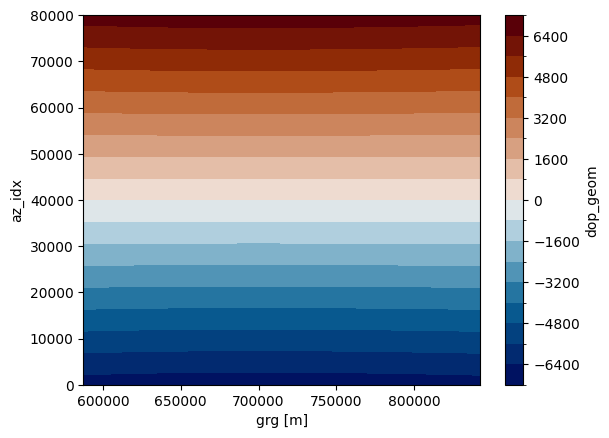

In [6]:
test.data.dop_geom.plot.contourf(robust = True, cmap = cmc.vik, levels = 20)

In [9]:
def geometric_Doppler(
        V_sat,
        Lambda, 
        angle_elevation, 
        angle_pitch, 
        angle_roll, 
        angle_yaw,
        angle_azimuth_original = 90,
        altitude_sat = 800E3,
        argument_of_latitude = 0, # 
        rotation_rate_earth = 7.2921150E-5,  # for non-roation Earth --> set to 0
        radius_earth = 6.371E6, 
        orbit_inclination = 98.7, 
        right_looking = True, 
        degrees = True,
        ):
    """
    From equation 5 in Wang et al., (1994) The effects of the attitude of the circular orbiting SAR on Doppler properties

    NOTE: currently assumes a flat Earth. This will skew `angle_earth_centre` (i.e. alpha in equation 5 of Wang et al., 1994). 
    NOTE: Therefore its recommended to put Earth rotation rate to 0, such that flat-earth approximation has little effect

    Parameters
    ----------
    V_sat: float,
        Satellite velocity
    Lambda: float,
        Radio wavelengths
    angle_elevation: float,
        elevation angle of satellite, see gamma in fig.1 of Raney 1986
    angle_pitch: float,
        pitch angle from boresight
    angle_roll: float,
        roll angle from boresight
    angle_yaw: float
        yaw angle from boresight
    angle_azimuth_original: 
        boresight direction with respect to azimuth plane, 90 degrees for right-looking radars
    altitude_sat: float
        altitude in meters
    argument_of_latitude: float
        relative latitude of orbit, e.g. for near polar orbit 0 is equator (central orbit) and 90 is near polar (the orbit maximum)
    rotation_rate_earth: float
        in rad, rotation rate of Earth, value from Wikipedia
    radius_earth: float
        in meters, average radius
    orbit_inclination: float,
        Google images will clarify
    right_looking: Bool default = True
        whether the radar looks right or left. Matters for rotating Earth
    degrees: Bool, default is True
        whether input angles are provided in degrees
    
    Ouput
    -----
    Doppler: float,
        geometric Doppler

    """

    if degrees:
        angle_elevation, angle_pitch, angle_roll, angle_yaw, angle_azimuth_original, argument_of_latitude, orbit_inclination = [np.deg2rad(i) for i in [angle_elevation, angle_pitch, angle_roll, angle_yaw, angle_azimuth_original, argument_of_latitude, orbit_inclination]]

    epsilon = 1 if right_looking else 0
    orbital_rate_sat = V_sat / (radius_earth + altitude_sat)
    range_slant = altitude_sat / np.cos(angle_elevation) # NOTE for flat Earth
    angle_earth_centre = np.arcsin(range_slant / radius_earth * np.sin(angle_elevation)) # from Figure 1 in Raney 1986

    s1 = 2*V_sat/Lambda 
    s1_1 = - np.cos(angle_elevation) * np.sin(angle_pitch) * np.sin(angle_roll) 
    s1_2 = np.sin(angle_elevation) * np.cos(angle_azimuth_original)
    s1_3 = np.sin(angle_yaw) * np.sin(angle_roll) * np.sin(angle_pitch) + np.cos(angle_pitch) * np.cos(angle_yaw)
    s2_1 = - epsilon * np.sin(angle_elevation) * np.sin(angle_azimuth_original)
    s2_2 = np.cos(angle_yaw) * np.sin(angle_roll) * np.sin(angle_pitch) - np.sin(angle_yaw) * np.cos(angle_pitch)
    e1 = - rotation_rate_earth / orbital_rate_sat
    e1_1 = - np.cos(argument_of_latitude) * np.sin(orbit_inclination)
    e2_1 = np.cos(angle_elevation) * np.sin(angle_roll) 
    e2_2 = np.sin(angle_elevation) * np.cos(angle_azimuth_original) * np.sin(angle_yaw) * np.cos(angle_roll)
    e2_3 = - epsilon * np.sin(angle_elevation) * np.sin(angle_azimuth_original) * np.cos(angle_yaw) * np.cos(angle_roll)
    e3 = np.cos(orbit_inclination)
    e3_1 = - np.cos(angle_elevation) * np.sin(angle_pitch) * np.cos(angle_roll)
    e3_2 = np.sin(angle_elevation) * np.cos(angle_earth_centre)
    e3_3 = np.sin(angle_yaw) * np.sin(angle_roll) * np.sin(angle_pitch) + np.cos(angle_pitch) * np.cos(angle_yaw)
    e4 = - epsilon * np.sin(angle_elevation) * np.sin(angle_earth_centre)
    e5_1 = np.cos(angle_yaw) * np.sin(angle_roll) * np.sin(angle_pitch) - np.sin(angle_yaw) * np.cos(angle_pitch)

    Doppler = (
        s1 * (s1_1 + s1_2 * (s1_3)
        + s2_1 * s2_2 + e1 * (e1_1 
        * (e2_1 + e2_2 + e2_3)
        + e3 * (e3_1 + e3_2 * (e3_3)
        + e4 * (e5_1)))
        )
    )

    return Doppler


def pointing_uncertainty(output, angles_elevation, angles_yaw, noise_yaws=[0], noise_rolls=[0], noise_pitches=[0], V_sat=6800, altitude_sat=8000, Lambda=5.56e-2, argument_of_latitude=0):

    for i, angle_elevation in tqdm(enumerate(angles_elevation)):
        for j, angle_yaw in enumerate(angles_yaw):
            for k, noise_yaw in enumerate(noise_yaws):
                for l, noise_roll in enumerate(noise_rolls):
                    for m, noise_pitch in enumerate(noise_pitches):

                        f_dop = geometric_Doppler(
                            V_sat = V_sat,
                            Lambda = Lambda, 
                            angle_elevation = angle_elevation, 
                            angle_pitch = 0.0, 
                            angle_roll = 0.0, 
                            angle_yaw = angle_yaw,
                            angle_azimuth_original = 90,
                            altitude_sat = altitude_sat,
                            argument_of_latitude = argument_of_latitude, 
                            rotation_rate_earth = 0,
                            radius_earth = 6.371E6, 
                            orbit_inclination = 98.7, 
                            right_looking = True, 
                            degrees = True,
                        )

                        f_dop_noise = geometric_Doppler(
                            V_sat = V_sat,
                            Lambda = Lambda, 
                            angle_elevation = angle_elevation, 
                            angle_pitch = noise_pitch, 
                            angle_roll = noise_roll, 
                            angle_yaw = angle_yaw + noise_yaw,
                            angle_azimuth_original = 90,
                            altitude_sat = altitude_sat,
                            argument_of_latitude = argument_of_latitude, 
                            rotation_rate_earth = 0,
                            radius_earth = 6.371E6, 
                            orbit_inclination = 98.7, 
                            right_looking = True, 
                            degrees = True,
                        )

                        output[i, j, k, l, m] = f_dop_noise - f_dop
    return output

@dask.delayed
def noise_MC(shape_output, angle_elevation, angle_yaw, noise_yaws, noise_rolls, noise_pitches, V_sat, Lambda, altitude_sat, argument_of_latitude):
    outputs = np.zeros(shape_output)
    for k, noise_yaw in enumerate(noise_yaws):
        for l, noise_roll in enumerate(noise_rolls):
            for m, noise_pitch in enumerate(noise_pitches):

                f_dop = geometric_Doppler(
                    V_sat = V_sat,
                    Lambda = Lambda, 
                    angle_elevation = angle_elevation, 
                    angle_pitch = 0.0, 
                    angle_roll = 0.0, 
                    angle_yaw = angle_yaw,
                    angle_azimuth_original = 90,
                    altitude_sat = altitude_sat,
                    argument_of_latitude = argument_of_latitude, 
                    rotation_rate_earth = 0,
                    radius_earth = 6.371E6, 
                    orbit_inclination = 98.7, 
                    right_looking = True, 
                    degrees = True,
                )

                f_dop_noise = geometric_Doppler(
                    V_sat = V_sat,
                    Lambda = Lambda, 
                    angle_elevation = angle_elevation, 
                    angle_pitch = noise_pitch, 
                    angle_roll = noise_roll, 
                    angle_yaw = angle_yaw + noise_yaw,
                    angle_azimuth_original = 90,
                    altitude_sat = altitude_sat,
                    argument_of_latitude = argument_of_latitude, 
                    rotation_rate_earth = 0,
                    radius_earth = 6.371E6, 
                    orbit_inclination = 98.7, 
                    right_looking = True, 
                    degrees = True,
                )

                outputs[k, l, m] = f_dop - f_dop_noise
    return outputs



        

def pointing_uncertainty_dask(angles_elevation, angles_yaw, noise_yaws=[0], noise_rolls=[0], noise_pitches=[0], V_sat=6800, altitude_sat=8000, Lambda=5.56e-2, argument_of_latitude=0):
    outputs = []
    shape_output = (len(noise_yaws), len(noise_rolls), len(noise_pitches))
    for i, angle_elevation in enumerate(angles_elevation):
        for j, angle_yaw in enumerate(angles_yaw):
            output = noise_MC(shape_output, angle_elevation, angle_yaw, noise_yaws, noise_rolls, noise_pitches, V_sat, Lambda, altitude_sat, argument_of_latitude)
            outputs.append(output)

    return outputs



In [40]:
f_dop = geometric_Doppler(
        V_sat = 6800,
        Lambda = 5.56e-2, 
        angle_elevation = 25, 
        angle_pitch = 10.000, 
        angle_roll = 0.00, 
        angle_yaw = 0.000,
        angle_azimuth_original = 90.1,
        altitude_sat = 800e3,
        argument_of_latitude = 0, 
        rotation_rate_earth = 0,
        radius_earth = 6.371E6, 
        orbit_inclination = 98.7, 
        right_looking = True, 
        degrees = True,
    )

f_dop

6.2336826812144315e-12

In [58]:
# ds = xr.Dataset(
#     data_vars=dict(
#         angles_elevation = (["idx_elevation"], np.arange(0, 90, 9)),
#         angles_yaw = (["idx_yaw"], np.arange(0, 90, 9)),
#         noise_yaw=(["N_yaw"], np.random.normal(size = N_samples) * accuracy_deg),
#         noise_roll=(["N_roll"], np.random.normal(size = N_samples) * accuracy_deg),
#         noise_pitch=(["N_pitch"], np.random.normal(size = N_samples) * accuracy_deg),
#     ),
#     coords=dict(
#         idx_elevation=(["idx_elevation"], np.arange(0, 90, 9)),
#         idx_yaw = (["idx_yaw"], np.arange(0, 90, 9)),
#         N_yaw = (["N_yaw"], np.arange(N_samples)),
#         N_roll = (["N_roll"], np.arange(N_samples)),
#         N_pitch = (["N_pitch"], np.arange(N_samples))
#     ),
# )

# ds.map_blocks


# ds

<xarray.Dataset>
Dimensions:           (idx_elevation: 10, idx_yaw: 10, N_yaw: 30, N_roll: 30,
                       N_pitch: 30)
Coordinates:
  * idx_elevation     (idx_elevation) int64 0 9 18 27 36 45 54 63 72 81
  * idx_yaw           (idx_yaw) int64 0 9 18 27 36 45 54 63 72 81
  * N_yaw             (N_yaw) int64 0 1 2 3 4 5 6 7 ... 22 23 24 25 26 27 28 29
  * N_roll            (N_roll) int64 0 1 2 3 4 5 6 7 ... 22 23 24 25 26 27 28 29
  * N_pitch           (N_pitch) int64 0 1 2 3 4 5 6 7 ... 23 24 25 26 27 28 29
Data variables:
    angles_elevation  (idx_elevation) int64 0 9 18 27 36 45 54 63 72 81
    angles_yaw        (idx_yaw) int64 0 9 18 27 36 45 54 63 72 81
    noise_yaw         (N_yaw) float64 0.0002669 -3.715e-05 ... 0.0002974
    noise_roll        (N_roll) float64 0.001036 -0.0006937 ... 0.0009244
    noise_pitch       (N_pitch) float64 -0.0006918 0.001213 ... -0.0007314

In [91]:
# %%time 
accuracy_arc_sec = 2
accuracy_deg = 0.01#accuracy_arc_sec / 3600
N_samples = 10
argument_of_latitude = 0
angles_elevation = np.arange(20, 60, 4)
yaws = np.arange(0, 90, 9)
noise_yaw = np.random.normal(size = N_samples) * 0#accuracy_deg
noise_roll = np.random.normal(size = N_samples) * accuracy_deg
noise_pitch = np.random.normal(size = N_samples) * accuracy_deg

shape_output = (len(angles_elevation),  len(yaws), len(noise_yaw), len(noise_roll), len(noise_pitch))
outputs = np.zeros (shape_output)


Lambda = test.Lambda
vx_sat = test.vx_sat
output_yaw_roll = pointing_uncertainty_dask(angles_elevation=angles_elevation, angles_yaw=yaws, noise_yaws=noise_yaw, noise_rolls=noise_roll, noise_pitches=noise_pitch, V_sat=vx_sat, altitude_sat=800E3, Lambda=Lambda)

In [70]:
dask.compute(output_yaw_roll)

([array([[[-0.29767099, -0.29766966, -0.29772553, ..., -0.29773497,
           -0.2977333 , -0.29767108],
          [-0.29767284, -0.29767156, -0.2977254 , ..., -0.29773449,
           -0.29773288, -0.29767293],
          [-0.29771297, -0.29771274, -0.29772254, ..., -0.29772419,
           -0.2977239 , -0.29771299],
          ...,
          [-0.2976614 , -0.29765982, -0.29772621, ..., -0.29773743,
           -0.29773544, -0.29766151],
          [-0.29778219, -0.29778376, -0.29771761, ..., -0.29770644,
           -0.29770842, -0.29778208],
          [-0.29774465, -0.29774524, -0.29772028, ..., -0.29771607,
           -0.29771682, -0.29774461]],
  
         [[ 1.23778256,  1.23778389,  1.23772802, ...,  1.23771858,
            1.23772025,  1.23778246],
          [ 1.2377807 ,  1.23778198,  1.23772815, ...,  1.23771905,
            1.23772066,  1.23778061],
          [ 1.23774057,  1.2377408 ,  1.237731  , ...,  1.23772935,
            1.23772964,  1.23774055],
          ...,
          [ 

In [94]:
# %%time 
accuracy_arc_sec = 2
accuracy_deg = 0.001#accuracy_arc_sec / 3600
N_samples = 10
argument_of_latitude = 0
angles_elevation = np.arange(20, 60, 4)
yaws = np.arange(0, 90, 9)
noise_yaw = np.random.normal(size = N_samples) * accuracy_deg
noise_roll = np.random.normal(size = N_samples) * accuracy_deg
noise_pitch = np.random.normal(size = N_samples) * accuracy_deg

shape_output = (len(angles_elevation),  len(yaws), len(noise_yaw), len(noise_roll), len(noise_pitch))
outputs = np.zeros (shape_output)


Lambda = test.Lambda
vx_sat = test.vx_sat
output_yaw_roll = pointing_uncertainty(output=outputs, 
                                       angles_elevation=angles_elevation, 
                                       angles_yaw=yaws, 
                                       noise_yaws=noise_yaw, 
                                       noise_rolls=noise_roll, 
                                       noise_pitches=noise_pitch, 
                                       V_sat=vx_sat, 
                                       altitude_sat=800E3, 
                                       Lambda=Lambda)

10it [00:05,  1.94it/s]


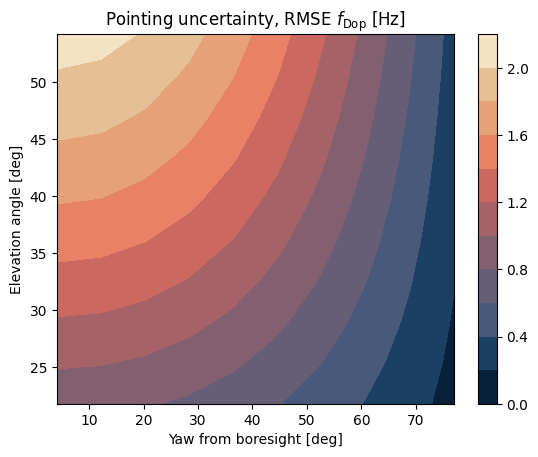

In [95]:
extent = [np.min(yaws), np.max(yaws), np.min(angles_elevation), np.max(angles_elevation)]
# cm = plt.cm.get_cmap('Reds',10)
# kwargs_plot = dict(origin = 'lower', cmap = cmc.batlowS(5), extent = extent, aspect = 'auto', interpolation = 'bilinear')
kwargs_plot = dict(origin = 'lower', cmap = cmc.lipari, extent = extent, levels = 10)

plt.contourf(np.sqrt(np.mean(output_yaw_roll**2, axis = (-3, -2, -1))), **kwargs_plot)
plt.xlabel('Yaw from boresight [deg]')
plt.ylabel('Elevation angle [deg]')
plt.title(r'Pointing uncertainty, RMSE $f_{\mathrm{Dop}}$ [Hz]')
_ = plt.colorbar()

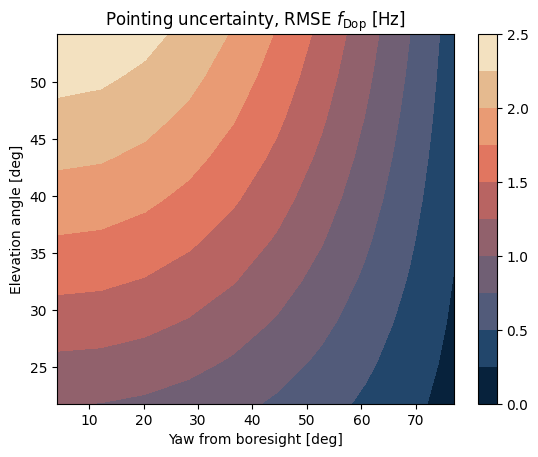

In [ ]:
extent = [np.min(yaws), np.max(yaws), np.min(angles_elevation), np.max(angles_elevation)]
# cm = plt.cm.get_cmap('Reds',10)
# kwargs_plot = dict(origin = 'lower', cmap = cmc.batlowS(5), extent = extent, aspect = 'auto', interpolation = 'bilinear')
kwargs_plot = dict(origin = 'lower', cmap = cmc.lipari, extent = extent, levels = 10)

plt.contourf(np.sqrt(np.mean(output_yaw_roll**2, axis = (-3, -2, -1))), **kwargs_plot)
plt.xlabel('Yaw from boresight [deg]')
plt.ylabel('Elevation angle [deg]')
plt.title(r'Pointing uncertainty, RMSE $f_{\mathrm{Dop}}$ [Hz]')
_ = plt.colorbar()